# COVID-19 Detection through chest radiograph analysis with Pytorch
### by Diego Garrocho
---
## Project Overview
1. Intro
2. Set up
3. Dataset Creation
4. Image Transformation
5. DataLoader
6. Data Visualization
7. Model Creation
8. Model Training 
9. Model eval

## 1. Intro
---
The coronavirus pandemic which started in December of 2019 has been an event that has changed completely changed the way the everyday is. The virus has proven to be highly spreadable and after infection the symptoms can vary from very mild to deadly. Most of the symptoms that are observed from the illness are presented on the respiratory system and can often lead to severe complications. There are many ways to detect the virus but one that is often overlooked is through the observation of chest x-rays.
With the help of Pytorch which is a machine learning tool it is possible to create a model and train it to detect if a radiograph has COVID-19 signs present.

## 2. Set up
---

In [1]:
 ! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegogarrocho","key":"580c0c313c66fcb46ce989fdcf50fb1d"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
 ! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-08-31 12:40:41          11465  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6959  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2700  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52           1756  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [6]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 741M/745M [00:09<00:00, 79.4MB/s]
100% 745M/745M [00:09<00:00, 83.9MB/s]


In [7]:
!unzip -q '/content/covid19-radiography-database.zip'

In [8]:
%matplotlib inline

import os
import shutil 
import random
import torch
import torchvision
import numpy as np
import errno

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Pytorch version: ', torch.__version__)

Pytorch version:  1.9.0+cu102


In [9]:
class_names = ['normal', 'viral', 'covid']
# root_dir = 'COVID-19 Radiography Database'
root_dir = '/content/COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

#err no 17 exempt
try:
    os.mkdir(root_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)


## 3. Dataset Creation
---


In [10]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

## 4. Image Transformation
---

In [11]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.4066],
                                    std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.4066],
                                    std=[0.229, 0.224, 0.225])
]) 

## 5. Dataloader
---
Fetches examples and gives them to the model in training

In [12]:
train_dirs = {
    'normal': f'/content/COVID-19_Radiography_Dataset/normal',
    'viral': f'/content/COVID-19_Radiography_Dataset/viral',
    'covid': f'/content/COVID-19_Radiography_Dataset/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [13]:
test_dirs = {
    'normal': f'/content/COVID-19_Radiography_Dataset/test/normal',
    'viral': f'/content/COVID-19_Radiography_Dataset/test/viral',
    'covid': f'/content/COVID-19_Radiography_Dataset/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [14]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                       shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                      shuffle=True)

print('Num of training batches: ', len(dl_train))
print('Num of test batches: ', len(dl_test))

Num of training batches:  2511
Num of test batches:  15


## 6. Data Visualization
---


In [18]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
  plt.figure(figsize=(8, 4))
  for i, image in enumerate(images):
    plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0., 1.)
    plt.imshow(image)

    col = 'green' if preds[i] == labels[i] else 'red'

    plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
    plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
  plt.tight_layout()
  plt.show()

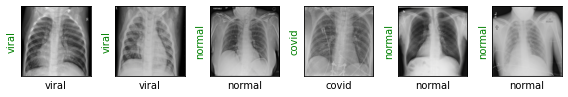

In [19]:
images, labels = next(iter(dl_train))
#labels twice because no preds yet
show_images(images, labels, labels)

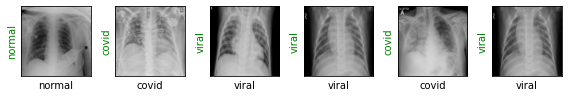

In [20]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## 7. Model Creation
---


In [21]:
#resnet due to time saving and still accurate enough
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
#chance number of features to just 3 (from 1000)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [23]:
def show_preds():
  resnet18.eval()
  images, labels = next(iter(dl_test))
  outputs = resnet18(images)
  _, preds = torch.max(outputs, 1)
  show_images(images, labels, preds)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


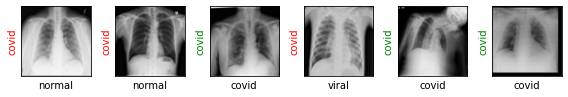

In [24]:
show_preds()

## 8. Model Training
---

In [25]:
def train(epochs):
  print('Starting training..')
  for e in range(0, epochs):
    print('='*20)
    print(f'Starting epoch {e+1}/{epochs}')
    print('='*20)

    train_loss = 0
    
    resnet18.train()

    for train_step, (images, labels) in enumerate(dl_train):
      optimizer.zero_grad()
      outputs = resnet18(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      if train_step % 20 == 0:
        print('Evaluating at step: ', train_step)
        acc = 0.
        val_loss = 0.
        resnet18.eval()

        for val_step, (images, labels) in enumerate(dl_test):
          outputs = resnet18(images)
          loss = loss_fn(outputs, labels)
          val_loss += loss.item()

          _, preds = torch.max(outputs, 1)
          acc += sum((preds == labels).numpy())
        
        val_loss /= (val_step + 1)
        acc = acc / len(test_dataset)
        print(f'Validation loss: {val_loss:.4f}, Accuracy: {acc:.4f}')
        show_preds()

        resnet18.train()

        if acc > 0.97:
          print('Perfomance condition met..')
          return

      train_loss /= (train_step +1)
      print(f'Training loss: {train_loss:.4f}')

Starting training..
Starting epoch 1/5
Evaluating at step:  0
Validation loss: 1.2170, Accuracy: 0.2111


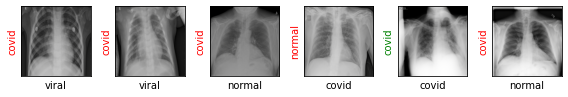

Training loss: 1.5211
Training loss: 1.2065
Training loss: 0.8570
Training loss: 0.4324
Training loss: 0.2823
Training loss: 0.2077
Training loss: 0.1431
Training loss: 0.1408
Training loss: 0.1219
Training loss: 0.0980
Training loss: 0.1250
Training loss: 0.0694
Training loss: 0.0548
Training loss: 0.0588
Training loss: 0.0478
Training loss: 0.0478
Training loss: 0.0619
Training loss: 0.0416
Training loss: 0.0466
Training loss: 0.0317
Evaluating at step:  20
Validation loss: 0.7127, Accuracy: 0.7778


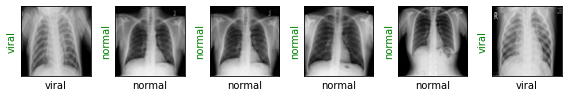

Training loss: 0.0200
Training loss: 0.0425
Training loss: 0.0194
Training loss: 0.0321
Training loss: 0.0236
Training loss: 0.0145
Training loss: 0.0228
Training loss: 0.0273
Training loss: 0.0318
Training loss: 0.0306
Training loss: 0.0210
Training loss: 0.0228
Training loss: 0.0121
Training loss: 0.0136
Training loss: 0.0298
Training loss: 0.0184
Training loss: 0.0181
Training loss: 0.0127
Training loss: 0.0189
Training loss: 0.0121
Evaluating at step:  40
Validation loss: 0.5068, Accuracy: 0.8778


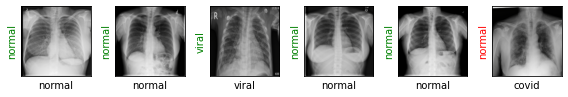

Training loss: 0.0198
Training loss: 0.0093
Training loss: 0.0085
Training loss: 0.0137
Training loss: 0.0067
Training loss: 0.0088
Training loss: 0.0064
Training loss: 0.0260
Training loss: 0.0075
Training loss: 0.0092
Training loss: 0.0124
Training loss: 0.0151
Training loss: 0.0049
Training loss: 0.0053
Training loss: 0.0089
Training loss: 0.0126
Training loss: 0.0111
Training loss: 0.0038
Training loss: 0.0042
Training loss: 0.0087
Evaluating at step:  60
Validation loss: 0.2854, Accuracy: 0.9222


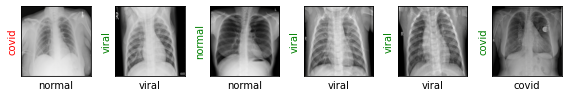

Training loss: 0.0103
Training loss: 0.0071
Training loss: 0.0055
Training loss: 0.0079
Training loss: 0.0066
Training loss: 0.0058
Training loss: 0.0045
Training loss: 0.0102
Training loss: 0.0064
Training loss: 0.0105
Training loss: 0.0014
Training loss: 0.0062
Training loss: 0.0081
Training loss: 0.0053
Training loss: 0.0078
Training loss: 0.0037
Training loss: 0.0079
Training loss: 0.0057
Training loss: 0.0063
Training loss: 0.0022
Evaluating at step:  80
Validation loss: 0.2131, Accuracy: 0.9222


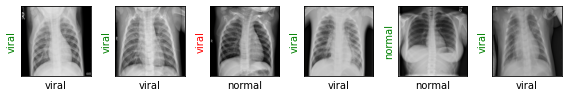

Training loss: 0.0037
Training loss: 0.0018
Training loss: 0.0078
Training loss: 0.0027
Training loss: 0.0046
Training loss: 0.0066
Training loss: 0.0035
Training loss: 0.0012
Training loss: 0.0032
Training loss: 0.0102
Training loss: 0.0019
Training loss: 0.0061
Training loss: 0.0023
Training loss: 0.0045
Training loss: 0.0023
Training loss: 0.0080
Training loss: 0.0023
Training loss: 0.0013
Training loss: 0.0017
Training loss: 0.0016
Evaluating at step:  100
Validation loss: 0.2186, Accuracy: 0.9556


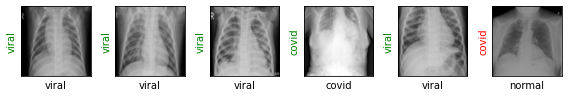

Training loss: 0.0015
Training loss: 0.0062
Training loss: 0.0039
Training loss: 0.0026
Training loss: 0.0009
Training loss: 0.0062
Training loss: 0.0020
Training loss: 0.0041
Training loss: 0.0025
Training loss: 0.0004
Training loss: 0.0036
Training loss: 0.0020
Training loss: 0.0059
Training loss: 0.0029
Training loss: 0.0009
Training loss: 0.0061
Training loss: 0.0013
Training loss: 0.0029
Training loss: 0.0012
Training loss: 0.0014
Evaluating at step:  120
Validation loss: 0.2195, Accuracy: 0.9444


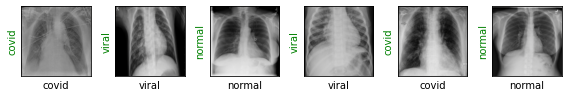

Training loss: 0.0053
Training loss: 0.0022
Training loss: 0.0051
Training loss: 0.0015
Training loss: 0.0004
Training loss: 0.0059
Training loss: 0.0024
Training loss: 0.0024
Training loss: 0.0028
Training loss: 0.0026
Training loss: 0.0070
Training loss: 0.0004
Training loss: 0.0013
Training loss: 0.0015
Training loss: 0.0011
Training loss: 0.0059
Training loss: 0.0042
Training loss: 0.0012
Training loss: 0.0046
Training loss: 0.0014
Evaluating at step:  140
Validation loss: 0.1711, Accuracy: 0.9667


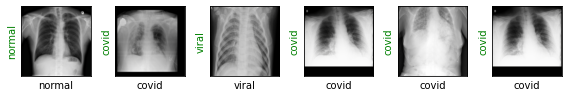

Training loss: 0.0029
Training loss: 0.0062
Training loss: 0.0080
Training loss: 0.0023
Training loss: 0.0036
Training loss: 0.0065
Training loss: 0.0009
Training loss: 0.0022
Training loss: 0.0008
Training loss: 0.0003
Training loss: 0.0005
Training loss: 0.0026
Training loss: 0.0023
Training loss: 0.0006
Training loss: 0.0042
Training loss: 0.0035
Training loss: 0.0012
Training loss: 0.0026
Training loss: 0.0012
Training loss: 0.0044
Evaluating at step:  160
Validation loss: 0.2599, Accuracy: 0.9111


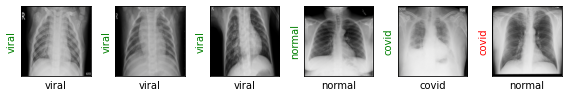

Training loss: 0.0037
Training loss: 0.0043
Training loss: 0.0023
Training loss: 0.0029
Training loss: 0.0039
Training loss: 0.0016
Training loss: 0.0023
Training loss: 0.0008
Training loss: 0.0015
Training loss: 0.0017
Training loss: 0.0022
Training loss: 0.0008
Training loss: 0.0011
Training loss: 0.0052
Training loss: 0.0005
Training loss: 0.0011
Training loss: 0.0097
Training loss: 0.0018
Training loss: 0.0018
Training loss: 0.0046
Evaluating at step:  180
Validation loss: 0.1882, Accuracy: 0.9333


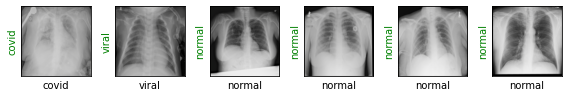

Training loss: 0.0016
Training loss: 0.0031
Training loss: 0.0028
Training loss: 0.0039
Training loss: 0.0023
Training loss: 0.0019
Training loss: 0.0018
Training loss: 0.0057
Training loss: 0.0024
Training loss: 0.0026
Training loss: 0.0017
Training loss: 0.0013
Training loss: 0.0013
Training loss: 0.0010
Training loss: 0.0014
Training loss: 0.0006
Training loss: 0.0023
Training loss: 0.0029
Training loss: 0.0015
Training loss: 0.0030
Evaluating at step:  200
Validation loss: 0.1888, Accuracy: 0.8889


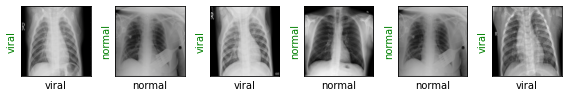

Training loss: 0.0032
Training loss: 0.0007
Training loss: 0.0022
Training loss: 0.0010
Training loss: 0.0015
Training loss: 0.0033
Training loss: 0.0010
Training loss: 0.0023
Training loss: 0.0015
Training loss: 0.0008
Training loss: 0.0021
Training loss: 0.0015
Training loss: 0.0011
Training loss: 0.0017
Training loss: 0.0014
Training loss: 0.0015
Training loss: 0.0018
Training loss: 0.0024
Training loss: 0.0012
Training loss: 0.0021
Evaluating at step:  220
Validation loss: 0.1323, Accuracy: 0.9889


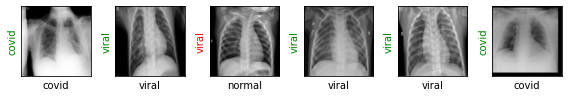

Perfomance condition met..


In [26]:
train(epochs=5)

## 9. Model Eval
---


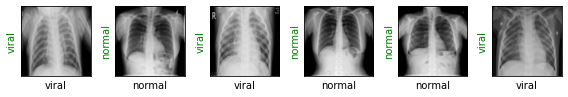

In [27]:
show_preds()